In [55]:
#916433470

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import pandas as pd
import csv

#### Data Processing

In [2]:
grocery_data = []

with open("Grocery_Items_5.csv", 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        data = [item for item in row.values() if item != '']
        grocery_data.append(data)


#### minimum support = 0.01 and minimum confidence threshold = 0.1

In [3]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules


te = TransactionEncoder()
te_ary = te.fit(grocery_data).transform(grocery_data)
grocery_df = pd.DataFrame(te_ary, columns=te.columns_)

itemsets = fpgrowth(grocery_df, min_support=0.01, use_colnames=True)
### alternatively:
#frequent_itemsets = apriori(grocery_df, min_support=0.6, use_colnames=True)
#frequent_itemsets = fpmax(grocery_df, min_support=0.6, use_colnames=True)
association_rules(itemsets, metric="confidence", min_threshold=0.1)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(yogurt),(whole milk),0.084000,0.158375,0.010500,0.125000,0.789266,-0.002803,0.961857
1,(soda),(whole milk),0.098250,0.158375,0.012125,0.123410,0.779224,-0.003435,0.960112
2,(other vegetables),(whole milk),0.122625,0.158375,0.014000,0.114169,0.720879,-0.005421,0.950097
3,(rolls/buns),(whole milk),0.108875,0.158375,0.013125,0.120551,0.761175,-0.004118,0.956991


#### Use minimum support values (msv): 0.001, 0.005, 0.01, 0.05 and minimum confidence threshold (mct): 0.05, 0.075, 0.1.

<AxesSubplot:xlabel='msv', ylabel='mct'>

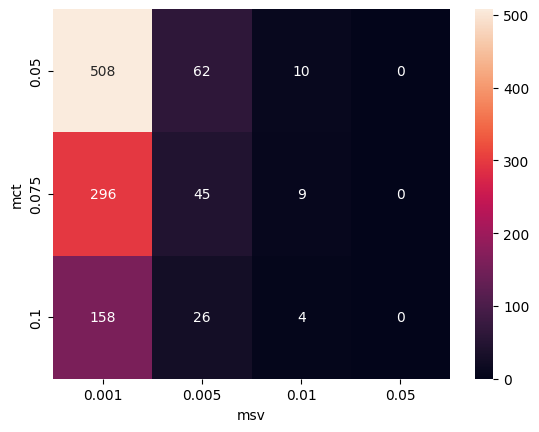

In [9]:
import seaborn as sns
msv,mct,num=[0.001, 0.005, 0.01, 0.05 ],[0.05, 0.075, 0.1],[]
rules_dict=[]
for i in msv:
    itemsets=fpgrowth(grocery_df,min_support=i,use_colnames=True)
    for j in mct:
        k=association_rules(itemsets,min_threshold=j,metric="confidence")
        num.append(len(k))
        rules_dict.append({
            'msv':i,
            "mct": j,
            "num":len(k)
        })
        
num_df = pd.DataFrame(rules_dict)

sns.heatmap(num_df.pivot('mct', 'msv', 'num'), annot=True,fmt='g')

        
        

#### the highest confidence for minimum support = 0.005

In [12]:
itemsets = fpgrowth(grocery_df, min_support=0.005, use_colnames=True)
rules=association_rules(itemsets, metric="confidence", min_threshold=0.0)
rules["confidence"].max()

0.17406143344709898

In [13]:
rules[rules['confidence']== 0.17406143344709898 ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,(domestic eggs),(whole milk),0.036625,0.158375,0.006375,0.174061,1.099046,0.000575,1.018992


#### Image Classification using CNN

In [14]:
CROPPED_PATH =  'cp'


In [34]:
def get_images_and_breeds(path):
    breeds= []
    images = []
    for i,name in enumerate(os.listdir(path)):
        p = os.path.join(path, name)
        files = os.listdir(p)
        imag = [file for file in files if file.lower().endswith(('.jpg'))]
        for image in imag:
            image_path = os.path.join(p, image)
            img = cv2.imread(image_path)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
            gray_image= cv2.resize(gray_image,(64,64))
            images.append(gray_image)
            breeds.append(i)
    return images,breeds

In [35]:
import os
import cv2
images,breeds=get_images_and_breeds(CROPPED_PATH)

In [36]:
images = np.array(images)
breeds  = np.array(breeds)

In [37]:
images=np.expand_dims(images,-1)

In [38]:
images.shape

(768, 64, 64, 1)

In [57]:
import tensorflow.keras as keras
breeds= keras.utils.to_categorical(breeds, 4)


In [40]:
from sklearn.model_selection import train_test_split
img_train,img_test,breed_train,breed_test=train_test_split(images,breeds,test_size=0.2,stratify=breeds)

In [41]:
 #1 Convolutional Layer with 8 3 × 3 filters.
#ii 1 max pooling with 2 × 2 pool size
#iii Flatten the Tensor
#iv 1 hidden layer with 16 nodes for fully connected neural network
#v Output layer has 4 nodes (since 4 classes) using ‘softmax’ activation function.


In [51]:
import matplotlib.pyplot as plt
def plot_accuracy(model):
    history=model.history.history
    plt.figure(figsize=(10,8))
    plt.plot(history['accuracy'],label='training-accuracy')
    plt.plot(history['val_accuracy'],label='validation-accuracy')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 7688)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                123024    
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 68        
Total params: 123,172
Trainable params: 123,172
Non-trainable params: 0
_________________________________________________________________
Train on 614 samples, validate on 154 samples
Epoch 1/20
614/614 [==============================] - 2s 3ms/sample

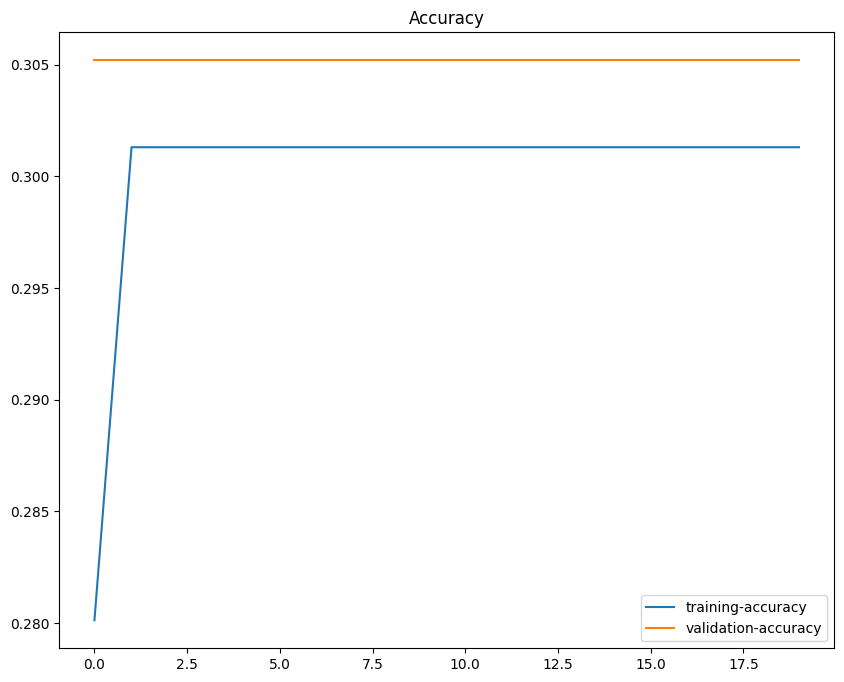

In [61]:
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Conv2D(8,(3,3),activation='relu', input_shape=img_train[0].shape))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(img_train, breed_train, batch_size=32, epochs=20, validation_data=(img_test,breed_test))
plot_accuracy(model)

In [46]:
#Train the CNN using 2 other filter sizes: 5 × 5 and 7 × 7 for the convolution layer (i) with all other parameters unchanged

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                115216    
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 68        
Total params: 115,492
Trainable params: 115,492
Non-trainable params: 0
_________________________________________________________________
Train on 614 samples, validate on 154 samples
Epoch 1/20
614/614 [==============================] - 2s 3ms/sample

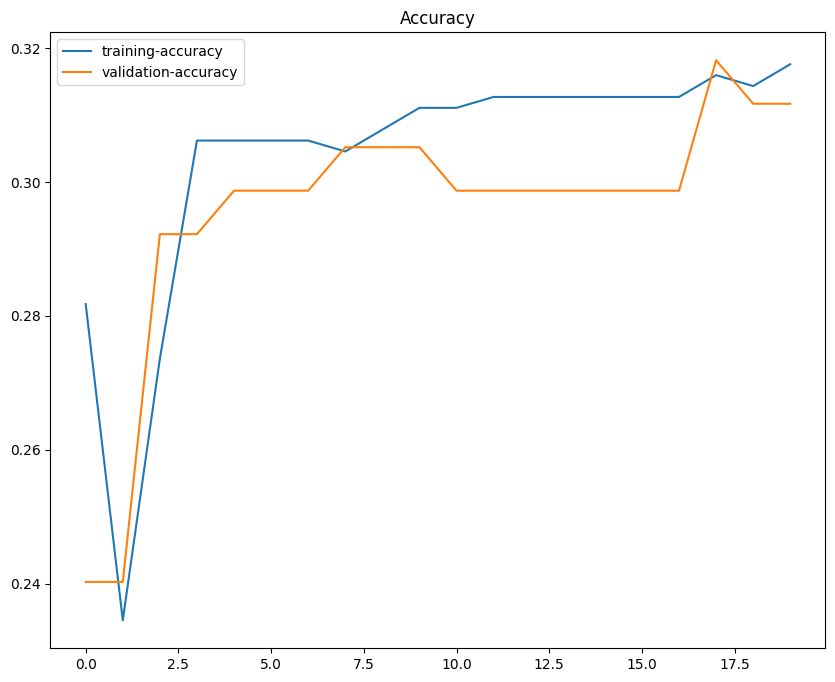

In [63]:
model = keras.models.Sequential()
model.add(layers.Conv2D(8,(5,5),activation='relu', input_shape=img_train[0].shape))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(img_train, breed_train, batch_size=32, epochs=20, validation_data=(img_test,breed_test))
plot_accuracy(model)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 58, 58, 8)         400       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6728)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                107664    
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 68        
Total params: 108,132
Trainable params: 108,132
Non-trainable params: 0
_________________________________________________________________
Train on 614 samples, validate on 154 samples
Epoch 1/20
614/614 [==============================] - 2s 3ms/sample

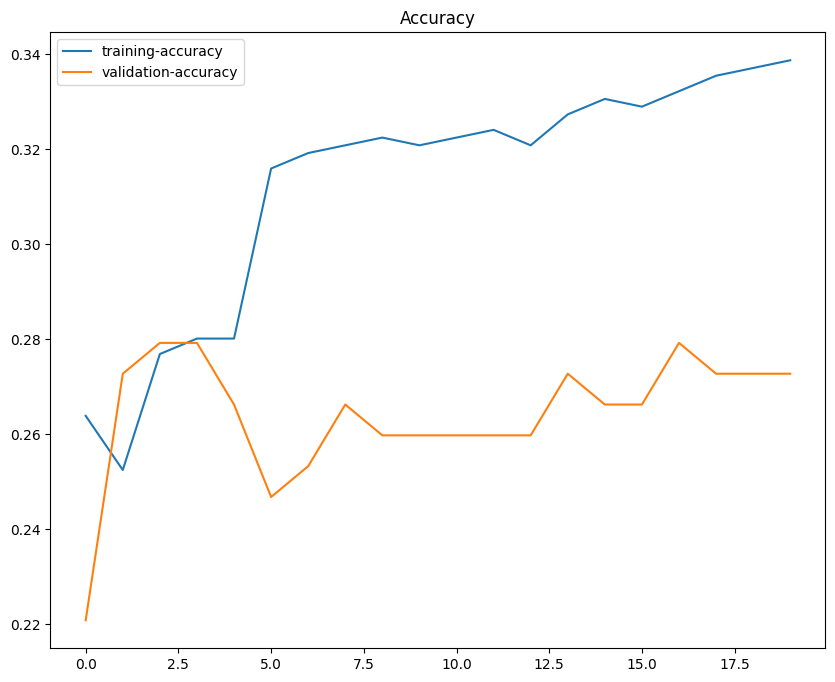

In [62]:
model = keras.models.Sequential()
model.add(layers.Conv2D(8,(7,7),activation='relu', input_shape=img_train[0].shape))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(img_train, breed_train, batch_size=32, epochs=20, validation_data=(img_test,breed_test))
plot_accuracy(model)

model with 3,3 kernal underfits

model with 5,5 kernal training accuracy is in sync with validation accuracy at some points but model overfits

model with 7,7 kernal has no much improvement in accuracy but the model overfits having huge gap betweeen validation and training

In [50]:
#https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#https://keras.io/examples/vision/mnist_convnet/